# OSIRIS image orientation

This code projects the comet North pole direction (positive right-handed spin axis) onto an OSIRIS image, at any given epoch.

Code courtesy of Jean-Baptiste Vincent, modified for use by Mark Bentley.

Notebook modified to work with PDS3 indexed meta-data in a pandas dataframe. This is updated with the output orientation vector and written out again.

In [3]:
import math
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
import spiceypy as spice

In [4]:
meta_kernel = '/home/mbentley/Dropbox/work/rosetta/rosetta/kernels/mk/ROS_OPS.TM'

In [5]:
def unit_vector(A):
    len = math.sqrt( sum([x*x for x in A]) )
    return [x/len for x in A]

In [6]:
def calc_comet_north(time_str):
    
    # Load kernels: FURNSH(path)
    spice.furnsh(meta_kernel)
    
    # Epochs in ephemeris time: STR2ET(time)
    et = spice.str2et(time_str)
    
    # Transformation matrix from comet frame to camera frame: PXFORM(frame_from, frame_to, ephemeris_time)
    mat_com2cam = spice.pxform("67P/C-G_CK", "ROS_OSIRIS_NAC", et)
   
    # Clear kernels from memory after use
    spice.kclear()

    # North direction in comet frame
    N_dir = [0,0,1]
    
    # Transform to camera frame
    N_dir_cam = mat_com2cam @ N_dir # Python 3.5+ can do matrix multiplication out of the box, cool !

    # Transform to image frame (the CCD is rotated by 90° and flipped vertically compared to the camera)
    N_dir_ccd = unit_vector( [N_dir_cam[1], -N_dir_cam[0]] )
    
    return N_dir_ccd

In [7]:
def show_comet_north(image, arrow_length=200):

    if type(image)==pd.DataFrame:
        image = image.iloc[0]

    im_path = image.browse_url
    vector = image.vector
    

    im = imageio.imread(im_path)    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), facecolor='white')
    ax.imshow(im, cmap="gray")
    ax.set_title(image.prod_id)
    ax.arrow(1700, 250, arrow_length * vector[0], arrow_length * vector[1], color=[1,1,0], head_width=50)


Find the corresponding archive images to the examples shown:
- NAC_2014-09-14T17.47.55.348Z_ID3F_1397549200_F22.jpg -> N20140914T174755348ID30F22
- NAC_2016-06-15T11.36.28.539Z_ID3F_1397549500_F22.jpg -> N20160615T113628539ID30F22

- NAC_2014-09-16T02.34.00.350Z_ID3F_1397549000_F22.jpg -> N20140916T023400350ID30F22
- NAC_2016-06-13T17.49.10.465Z_ID3F_1397549800_F22.jpg -> N20160613T174910465ID30F22

- NAC_2014-09-13T21.48.48.344Z_ID3F_1397549200_F22.jpg -> N20140913T214848344ID30F22
- NAC_2016-06-15T16.47.53.702Z_ID3F_1397549700_F22.jpg -> N20160615T164753702ID30F22

- NAC_2014-09-20T11.53.25.342Z_ID3F_1397549500_F22.jpg -> N20140920T115325342ID30F22
- NAC_2016-06-16T10.32.12.545Z_ID3F_1397549500_F22.jpg -> N20160616T103212545ID30F22


In [8]:
pairs = [
    ('N20140914T174755348ID30F22.FIT', 'N20160615T113628539ID30F22.FIT'),
    ('N20140916T023400350ID30F22.FIT', 'N20160613T174910465ID30F22.FIT'),
    ('N20140913T214848344ID30F22.FIT', 'N20160615T164753702ID30F22.FIT'),
    ('N20140920T115325342ID30F22.FIT', 'N20160616T103212545ID30F22.FIT')
]

In [9]:
data_path = '.'
images = pd.read_csv(os.path.join(data_path, 'osinac_metadata.csv.gz'))
images.start_time = pd.to_datetime(images.start_time)
images.stop_time = pd.to_datetime(images.stop_time)

Add the image orientation vector to every image

In [10]:
images['vector'] = images.start_time.apply( lambda t: calc_comet_north(t.strftime('%Y-%m-%d %X')))

Check that this works with the first image in the set

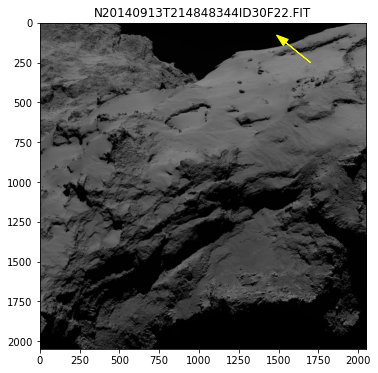

In [11]:
show_comet_north(images.iloc[0])

The following test data were provided by JB - here I simply re-run these same data using the DataFrame produced from the archive labels to be sure that we get the same results.

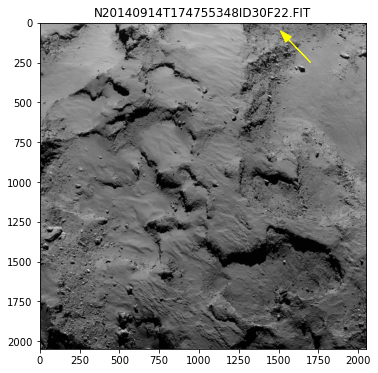

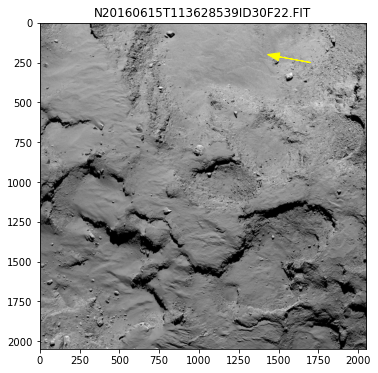

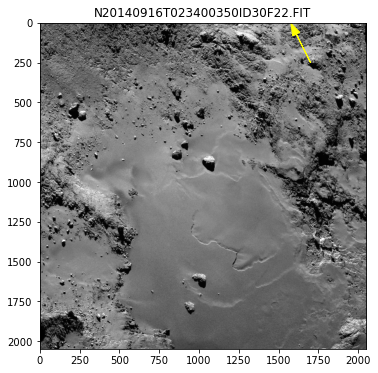

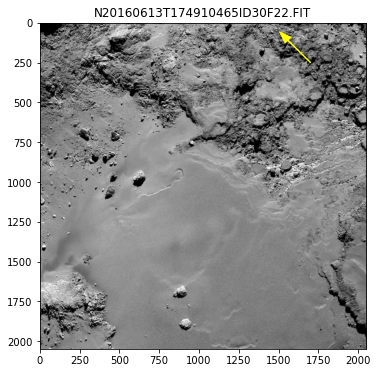

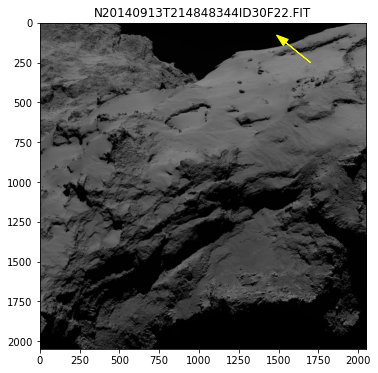

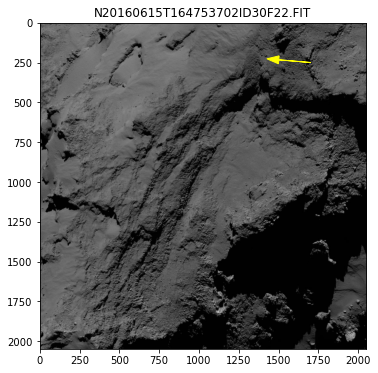

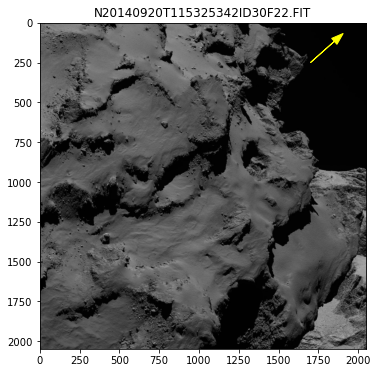

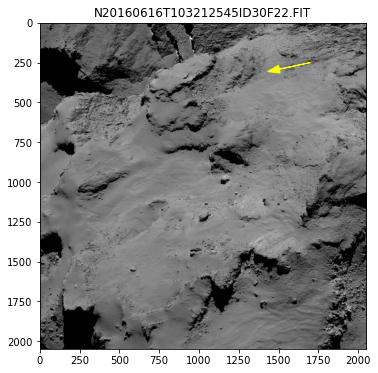

In [12]:
# TESTS Comet North
    
# Agilkia
# show_comet_north("2014-09-14T17:49:04", "./NAC_2014-09-14T17.47.55.348Z_ID3F_1397549200_F22.jpg")
# show_comet_north("2016-06-15T11:37:55", "./NAC_2016-06-15T11.36.28.539Z_ID3F_1397549500_F22.jpg")
show_comet_north(images[images.prod_id==pairs[0][0]])
show_comet_north(images[images.prod_id==pairs[0][1]])


# Imhotep
# show_comet_north("2014-09-16T02:35:09", "./NAC_2014-09-16T02.34.00.350Z_ID3F_1397549000_F22.jpg")
# show_comet_north("2016-06-13T17:50:36", "./NAC_2016-06-13T17.49.10.465Z_ID3F_1397549800_F22.jpg")
show_comet_north(images[images.prod_id==pairs[1][0]])
show_comet_north(images[images.prod_id==pairs[1][1]])


# Ash
# show_comet_north("2014-09-13T21:49:57", "./NAC_2014-09-13T21.48.48.344Z_ID3F_1397549200_F22.jpg")
# show_comet_north("2016-06-15T16:49:20", "./NAC_2016-06-15T16.47.53.702Z_ID3F_1397549700_F22.jpg")
show_comet_north(images[images.prod_id==pairs[2][0]])
show_comet_north(images[images.prod_id==pairs[2][1]])

# Ma'at
# show_comet_north("2014-09-20T11:54:34", "./NAC_2014-09-20T11.53.25.342Z_ID3F_1397549500_F22.jpg")
# show_comet_north("2016-06-16T10:33:39", "./NAC_2016-06-16T10.32.12.545Z_ID3F_1397549500_F22.jpg")
show_comet_north(images[images.prod_id==pairs[3][0]])
show_comet_north(images[images.prod_id==pairs[3][1]])



These look identical to the originals, so now we can write out the new, updated, df to be used later in pair production.

Since the vector column would not be correctly serialised to the CSV we split it into two columns

In [17]:
images['vec1'] = images.vector.apply( lambda vec: vec[0])
images['vec2'] = images.vector.apply( lambda vec: vec[1])
images.drop('vector', inplace=True, axis=1)

In [18]:
images.to_csv(os.path.join(data_path, 'osinac_metadata_orientation.csv.gz'), index=False)